In [43]:
%%capture

!git clone https://github.com/jlindbloom/Math76MRI.git

# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install xdesign


import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from fastprogress import progress_bar


# Go back to MRI folder
os.chdir("Math76MRI")
os.listdir()

# This is importing some of the code I gave you
from util import make_shepp_logan_image, line_mask

# !pip install --upgrade "jaxlib==0.3.14+cuda11.cudnn805" -f https://storage.googleapis.com/jax-releases/jax_releases.html

# 1. Make the noisy observation

In [44]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import scipy.sparse as sp

In [45]:
# Problem parameters
spatial_resolution = 120
#freq = np.ceil(spatial_resolution*np.pi/8)
freq = np.ceil(spatial_resolution*np.pi/12)

# Create angles and FFT mask
thetas = np.arange(0, 180, 180/freq)
phantom_resolution = 2*spatial_resolution + 1
phantom = make_shepp_logan_image(phantom_resolution)
L = len(thetas)
Ny = 2*spatial_resolution + 1
Nx = 2*spatial_resolution + 1
R, Mh, mi, mhi = line_mask(L, Ny, Nx)
R = R.astype(np.float64)
BPR = np.real( np.fft.ifft2( R*np.fft.fft2(phantom) ) ) # backprojection

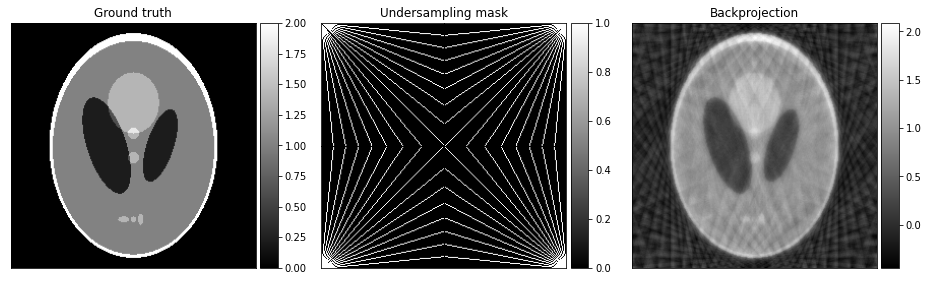

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(13,8))

img = phantom

im1 = axs[0].imshow(img, cmap="gray")
ax1_divider = make_axes_locatable(axs[0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
axs[0].set_title("Ground truth")

im2 = axs[1].imshow(R, cmap="gray")
ax2_divider = make_axes_locatable(axs[1])
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2)
axs[1].set_title("Undersampling mask")

im3 = axs[2].imshow(BPR, cmap="gray")
ax3_divider = make_axes_locatable(axs[2])
cax3 = ax3_divider.append_axes("right", size="7%", pad="2%")
cb3 = fig.colorbar(im3, cax=cax3)
axs[2].set_title("Backprojection")


for ax in axs.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
    
fig.savefig("data.png", dpi=1000, bbox_inches="tight")
fig.savefig("data.eps", bbox_inches="tight")

In [47]:
# Makes the 1D TV operator
tv_mat = sp.eye(2*spatial_resolution + 1) - sp.diags( np.ones(2*spatial_resolution) , offsets=1)
tv_mat = tv_mat[:-1,:] # Remove last row to remove zero BC
tv_mat_t = tv_mat.T # TV^T
tv_mat_t_tv_mat = tv_mat_t @ tv_mat # TV^T @ TV

# 2. Split-Bregman

In [48]:
def calc_objective_value(x, fourier_observation, lam):

  data_fidelity = np.linalg.norm( ( R*np.fft.fft2(x, norm="ortho") - fourier_observation ).flatten(), ord=2)**2
  
  # I will fix this later, but for now a cheat
  regularization = lam*( np.abs(x[1:,:] - x[:-1,:]).sum() + np.abs(x[:,1:] - x[:,:-1]).sum() )

  return data_fidelity + regularization

In [49]:
def do_split_bregman(n_inner=1, n_outer=35, lam=1, cg_max_its=200):

  # Masked Fourier observation
  f = R*np.fft.fft2(phantom)

  uk = np.fft.ifft2(R*f)

  dk_x = np.zeros((2*spatial_resolution, 2*spatial_resolution + 1))
  dk_y = np.zeros((2*spatial_resolution + 1, 2*spatial_resolution))

  bk_x = dk_x.copy()
  bk_y = dk_y.copy()
  fk = f.copy()

  # for j_outer in progress_bar(range(n_outer)):
  #     for j_inner in range(n_inner):
  obj_vals = []
  for j_outer in progress_bar(range(n_outer)):
      for j_inner in range(n_inner):

          rhs = np.fft.ifft2(R*fk)
          rhs += lam * tv_mat_t @ (dk_x-bk_x)
          rhs += lam * (dk_y-bk_y) @ tv_mat

          ### L2 minimization step
          r = rhs - np.fft.ifft2(R*np.fft.fft2(uk))
          r -= lam * tv_mat_t_tv_mat @ uk
          r -= lam * uk @ tv_mat_t_tv_mat

          # Flatten
          r = r.flatten()
          uk = uk.flatten()

          # Conjugate gradient sub-problem
          p = r.copy()
          rsold = np.conjugate(r.T) @ r # dot product
          for i in range(cg_max_its): # subiterations
              p = np.reshape(p, (2*spatial_resolution+1, 2*spatial_resolution+1))
              
              Ap = np.fft.ifft2(R*np.fft.fft2(p))
              Ap += lam * tv_mat_t_tv_mat @ p
              Ap += lam * p @ tv_mat_t_tv_mat

              # Flatten
              Ap = Ap.flatten()
              p = p.flatten()

              # Calculate stuff
              alpha = rsold/(np.conjugate(p.T) @ Ap) # has dot product in denominator
              uk += alpha*p
              r -= alpha*Ap
              rsnew = np.conjugate(r.T) @ r # dot product
              if np.sqrt(rsnew) < 1e-10:
                  break
              
              p = r + (rsnew/rsold)*p
              rsold = rsnew
          
          uk = np.reshape(uk, (2*spatial_resolution+1, 2*spatial_resolution+1))
          

          ### L1 optimization of dk directly by shrink operator
          sk_x = np.sqrt( (tv_mat @ uk + bk_x)**2 )
          dk_x = np.maximum( np.abs(sk_x)-1/lam, 0) * (tv_mat @ uk + bk_x)/sk_x
          bk_x = bk_x + tv_mat @ uk - dk_x
          sk_y = np.sqrt( (uk @ tv_mat_t + bk_y)**2 )
          dk_y = np.maximum( np.abs(sk_y)-1/lam, 0) * ( uk @ tv_mat_t + bk_y)/sk_y
          bk_y = bk_y + uk @ tv_mat_t - dk_y

      # Update fk
      fk += f - R*np.fft.fft2(uk)


      # Calculate objective function
      obj_vals.append( calc_objective_value(np.real(uk), f, 1) )

  # Final solution is real part of uk
  tv_reconstruction = np.real(uk)

  return tv_reconstruction, obj_vals
  #return tv_reconstruction


In [50]:
# Ground truth
ground_truth_estimate, obj_vals = do_split_bregman(n_inner=1, n_outer=20, lam=1000)

In [51]:
estimate_for_20 = ground_truth_estimate.copy()

In [52]:
estimate_for_100 = ground_truth_estimate.copy()

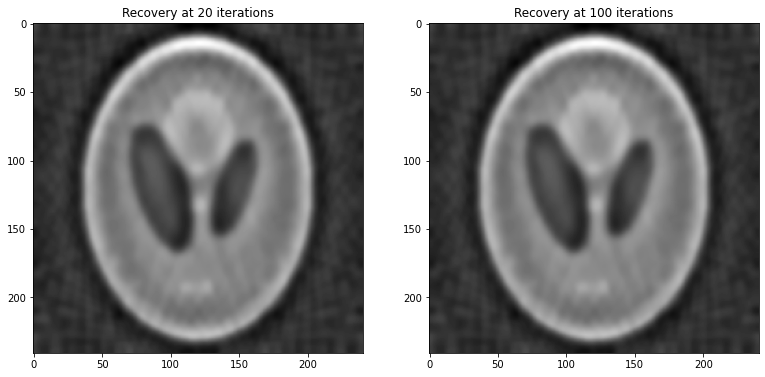

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(13,8))

axs[0].imshow(estimate_for_20, cmap="gray")
axs[0].set_title("Recovery at 20 iterations")

axs[1].imshow(estimate_for_100, cmap="gray")
axs[1].set_title("Recovery at 100 iterations")

fig.savefig("split_bregman_recon.png", dpi=1000, bbox_inches="tight")
fig.savefig("split_bregman_recon.eps", bbox_inches="tight")

plt.show()

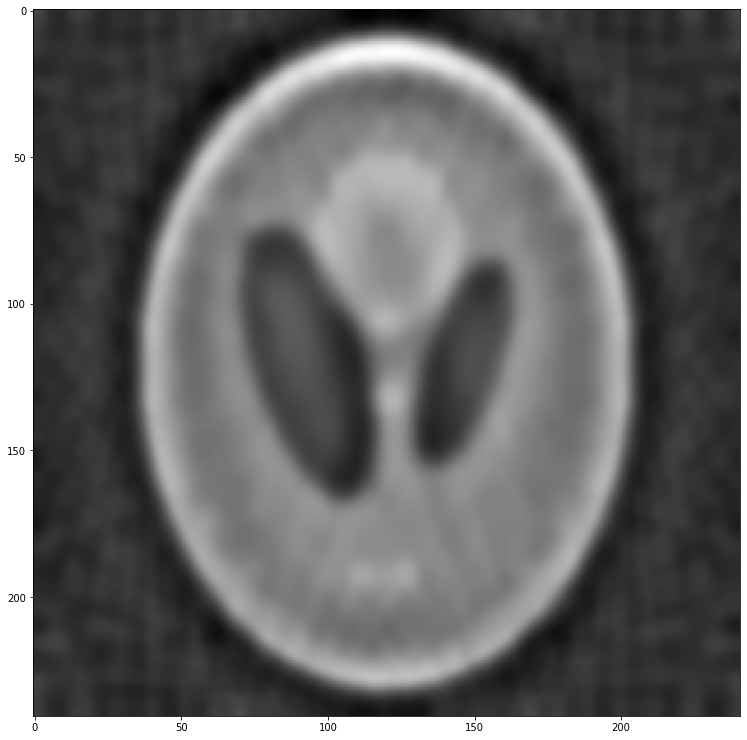

In [54]:
plt.figure(figsize=(13,13))
plt.imshow(estimate_for_100, cmap="gray")
plt.show()

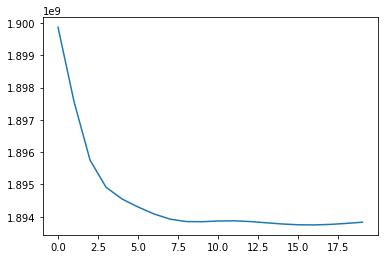

In [55]:
plt.plot(obj_vals)
plt.show()

In [56]:
os.getcwd()

'/content/Math76MRI/Math76MRI'

# 3. Setting up the other 3 methods

In [57]:
import jax

import scico
import scico.numpy as snp
import scico.random
from scico import denoiser, functional, linop, loss, metric, plot
from scico.data import kodim23
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.solver import cg
from scico.util import device_info

from scico.linop import DFT
from scico.linop import LinearOperator

plot.config_notebook_plotting()

In [58]:
from __future__ import annotations

from typing import Optional, Sequence

import numpy as np

import scico.numpy as snp
from scico.typing import JaxArray, Shape


class MyDFT(LinearOperator):
    r"""Multi-dimensional discrete Fourier transform."""

    def __init__(
        self,
        input_shape: Shape,
        axes: Optional[Sequence] = None,
        axes_shape: Optional[Shape] = None,
        norm: Optional[str] = None,
        jit: bool = True,
        **kwargs,
    ):
        r"""
        Args:
            input_shape: Shape of input array.
            axes: Axes over which to compute the DFT. If ``None``, the
                DFT is computed over all axes.
            axes_shape: Output shape on the subset of array axes selected
                by `axes`. This parameter has the same behavior as the
                `s` parameter of :func:`numpy.fft.fftn`.
            norm: DFT normalization mode. See the `norm` parameter of
                :func:`numpy.fft.fftn`.
            jit: If ``True``, jit the evaluation, adjoint, and gram
                functions of the LinearOperator.
        """
        if axes is not None and axes_shape is not None and len(axes) != len(axes_shape):
            raise ValueError(
                f"len(axes)={len(axes)} does not equal len(axes_shape)={len(axes_shape)}"
            )

        if axes_shape is not None:
            if axes is None:
                axes = tuple(range(len(input_shape) - len(axes_shape), len(input_shape)))
            tmp_output_shape = list(input_shape)
            for i, s in zip(axes, axes_shape):
                tmp_output_shape[i] = s
            output_shape = tuple(tmp_output_shape)
        else:
            output_shape = input_shape

        if axes is None or axes_shape is None:
            self.inv_axes_shape = None
        else:
            self.inv_axes_shape = [input_shape[i] for i in axes]

        self.axes = axes
        self.axes_shape = axes_shape
        self.norm = norm

        # To satisfy mypy -- DFT shapes must be tuples, not list of tuple
        # These get set inside of super().__init__ call, but we want to have
        # more restrictive type than the general LinearOperator
        self.input_shape: Shape
        self.output_shape: Shape

        super().__init__(
            input_shape=input_shape,
            output_shape=output_shape,
            input_dtype=np.float32,
            output_dtype=np.complex64,
            jit=jit,
            **kwargs,
        )

    def _eval(self, x: JaxArray) -> JaxArray:
        return snp.fft.fftn(x, s=self.axes_shape, axes=self.axes, norm=self.norm)

    def inv(self, z: JaxArray) -> JaxArray:
        """Compute the inverse of this LinearOperator.
        Compute the inverse of this LinearOperator applied to `z`.
        Args:
            z: Input array to inverse DFT.
        """
        return snp.fft.ifftn(z, s=self.inv_axes_shape, axes=self.axes, norm=self.norm)

In [59]:
# Image we are denoising
img = phantom[None,:,:]
img = jax.device_put(img)

# Also bring the line mask onto GPU
mask_array = jax.device_put(R.flatten())
idx_nonzero = np.where(R.flatten() > 0)
idx_nonzero = jax.device_put(idx_nonzero)

# Define the DFT linear operator
dft_op = MyDFT(img.shape)

# Define the undersampling operator

eval_fn = lambda x: x.flatten()[idx_nonzero]
eval_fn_transpose = lambda x: x.T.flatten()[idx_nonzero]

undersampling_op = LinearOperator(img.shape, eval_fn=eval_fn, input_dtype=np.complex64)


# Define the composed operator
mri_op = undersampling_op @ dft_op

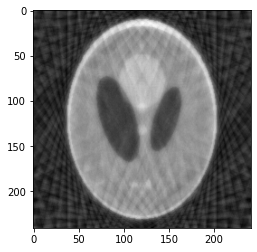

In [60]:
noise_sigma = 0.00
x_with_op_applied = mri_op._eval(img)
y_obs = x_with_op_applied + noise_sigma*jax.device_put( np.random.normal(size=x_with_op_applied.shape) )

BP = np.zeros(img.shape).astype(np.complex64)
BP = BP.flatten()
BP[idx_nonzero] = y_obs
BP = BP.reshape(img.shape)
BP = np.real(np.fft.ifft2(BP[0,:,:]))

plt.imshow(BP, cmap="gray")
plt.show()

### First do ADMM

In [61]:
# #λ = 2e-2  # L1 norm regularization parameter
# λ = 2e-2
# ρ = 5e-0  # ADMM penalty parameter
# maxiter = 50  # number of ADMM iterations

λ = 1000  # L1 norm regularization parameter ()
ρ = 5e1  # ADMM penalty parameter
maxiter = 3000  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y_obs, A=mri_op)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
g = λ * functional.L1Norm()  # regularization functionals gi
C = linop.FiniteDifference(input_shape=img.shape, input_dtype=np.float32)  # analysis operators Ci
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=snp.real(mri_op.adj(y_obs)),
    #x0 = jax.device_put(img),
    maxiter=maxiter,
    #subproblem_solver=LinearSubproblemSolver()
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol":1e-6}),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
x = solver_admm.solve()
hist_admm = solver_admm.itstat_object.history(transpose=True)

Solving on GPU (Tesla T4)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.23e-01  9.580e+10  6.145e+03  1.777e+06    100  4.465e-05
  10  2.12e+00  1.020e+09  9.435e+02  3.155e+03    100  1.068e-05
  20  3.97e+00  1.613e+08  4.214e+02  1.484e+03     95  7.772e-07
  30  5.49e+00  1.755e+06  2.014e+02  2.967e+02     69  8.351e-07
  40  6.29e+00  1.224e+06  3.151e+01  5.915e+00     25  9.618e-07
  50  6.89e+00  1.514e+06  2.805e+01  6.571e+00     28  9.876e-07
  60  7.48e+00  1.761e+06  2.466e+01  7.240e+00     25  9.674e-07
  70  8.12e+00  2.014e+06  2.075e+01  6.773e+00     30  7.191e-07
  80  8.67e+00  2.147e+06  1.819e+01  5.090e+00     22  9.685e-07
  90  9.18e+00  2.246e+06  1.636e+01  4.537e+00     19  8.378e-07
 100  9.66e+00  2.335e+06  1.481e+01  3.675e+00     19  8.791e-07
 110  1.02e+01  2.396e+06  1.368e+01  2.606e+00     16  8.135e-07
 120  1.13e+01  2.471e+06  1.244e+01  2.796e+00  

### Do PDGH

In [62]:
from scico.optimize import PDHG

solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=4e-2,
    sigma=4e-0,
    maxiter=3000,
    x0 = snp.real(mri_op.adj(y_obs)),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
x_pdhg = solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)

Solving on GPU (Tesla T4)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  3.31e-02  5.965e+11  2.615e+08  8.315e+04
  10  5.61e-01  1.149e+09  4.563e+04  4.348e+03
  20  1.06e+00  5.888e+08  2.411e+04  2.407e+03
  30  1.56e+00  4.163e+08  1.587e+04  1.630e+03
  40  2.04e+00  3.045e+08  1.205e+04  1.190e+03
  50  2.53e+00  2.459e+08  8.936e+03  9.587e+02
  60  3.02e+00  1.815e+08  7.654e+03  6.997e+02
  70  3.51e+00  1.614e+08  5.698e+03  6.114e+02
  80  4.01e+00  1.272e+08  4.862e+03  4.954e+02
  90  4.50e+00  1.011e+08  4.293e+03  3.736e+02
 100  5.01e+00  9.760e+07  2.979e+03  3.728e+02
 110  5.52e+00  6.508e+07  3.214e+03  2.522e+02
 120  6.04e+00  7.270e+07  2.024e+03  2.713e+02
 130  6.55e+00  4.670e+07  2.355e+03  1.846e+02
 140  7.03e+00  5.466e+07  1.482e+03  1.984e+02
 150  7.53e+00  3.563e+07  1.722e+03  1.405e+02
 160  8.02e+00  4.058e+07  1.144e+03  1.462e+02
 170  8.51e+00  2.910e+07  1.241e+03  1.119e+02
 180  9.02e+0

### Then do LADMM

In [63]:
from scico.optimize import LinearizedADMM

solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=3e-2,
    nu=2e-1,
    x0 = snp.real(mri_op.adj(y_obs)),
    maxiter=3000,
    itstat_options={"display": True, "period": 10},
)
x_ladmm = solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)
#print(f"PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB\n")

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  2.99e-02  1.060e+12  1.169e+03  1.784e+06
  10  5.22e-01  1.315e+03  3.390e+01  0.000e+00
  20  9.88e-01  1.953e+03  3.366e+01  0.000e+00
  30  1.36e+00  2.715e+03  3.358e+01  0.000e+00
  40  1.84e+00  3.598e+03  3.366e+01  0.000e+00
  50  2.22e+00  4.592e+03  3.344e+01  0.000e+00
  60  2.59e+00  5.704e+03  3.336e+01  0.000e+00
  70  3.06e+00  6.922e+03  3.335e+01  0.000e+00
  80  3.46e+00  8.260e+03  3.322e+01  0.000e+00
  90  3.83e+00  9.702e+03  3.315e+01  0.000e+00
 100  4.27e+00  1.125e+04  3.308e+01  0.000e+00
 110  4.62e+00  1.290e+04  3.301e+01  0.000e+00
 120  5.00e+00  1.464e+04  3.326e+01  0.000e+00
 130  5.50e+00  1.650e+04  3.291e+01  0.000e+00
 140  5.90e+00  1.845e+04  3.281e+01  0.000e+00
 150  6.25e+00  2.050e+04  3.275e+01  0.000e+00
 160  6.68e+00  2.264e+04  3.268e+01  0.000e+00
 170  7.07e+00  2.487e+04  3.262e+01  0.000e+00
 180  7.44e+00  2.719e+04  3.255e+01  0.

# Now analyze the results

In [64]:
admm_sol = np.real(np.asarray(solver_admm.x))[0,:,:]
ladmm_sol = np.real(np.asarray(solver_ladmm.x))[0,:,:]
pdhg_sol = np.real(np.asarray(solver_pdhg.x))[0,:,:]

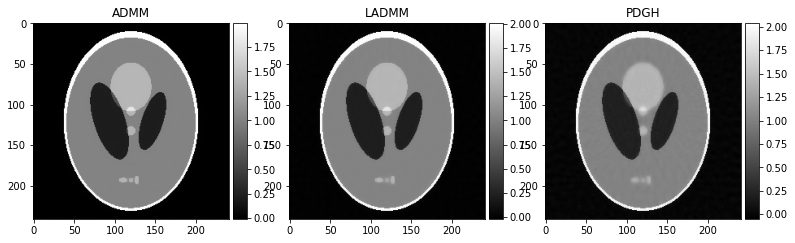

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(13,8))

img = phantom

im1 = axs[0].imshow(admm_sol, cmap="gray")
ax1_divider = make_axes_locatable(axs[0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
axs[0].set_title("ADMM")

im2 = axs[1].imshow(ladmm_sol, cmap="gray")
ax2_divider = make_axes_locatable(axs[1])
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2)
axs[1].set_title("LADMM")

im3 = axs[2].imshow(pdhg_sol, cmap="gray")
ax3_divider = make_axes_locatable(axs[2])
cax3 = ax3_divider.append_axes("right", size="7%", pad="2%")
cb3 = fig.colorbar(im3, cax=cax3)
axs[2].set_title("PDGH")

fig.show()

# for ax in axs.reshape(-1):
#     ax.set_xticks([])
#     ax.set_yticks([])
    
# fig.tight_layout()
    
fig.savefig("mri_solver_comparison.png", dpi=1000, bbox_inches="tight")
fig.savefig("mri_solver_comparison.eps", bbox_inches="tight")

# plt.show()

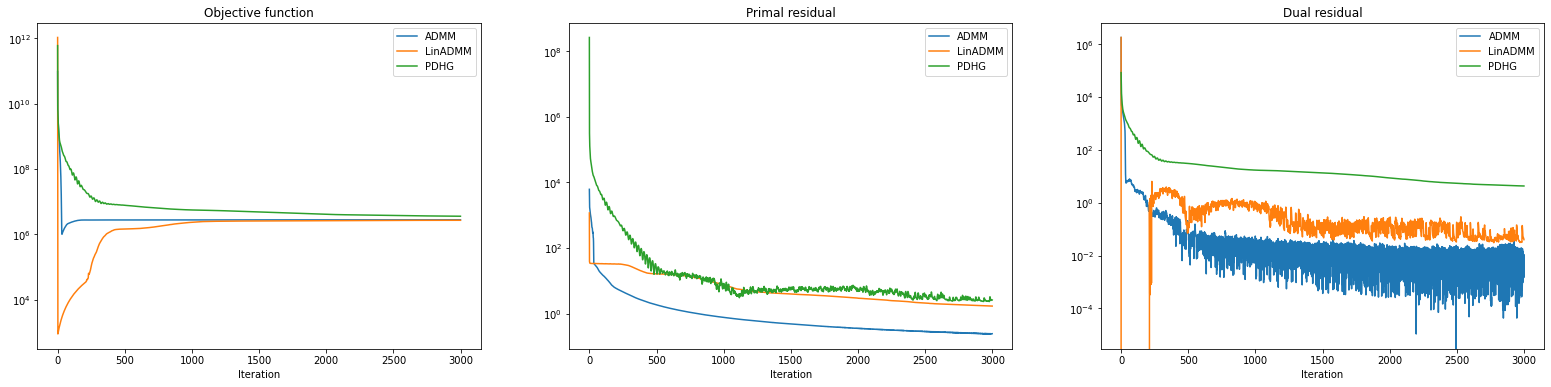

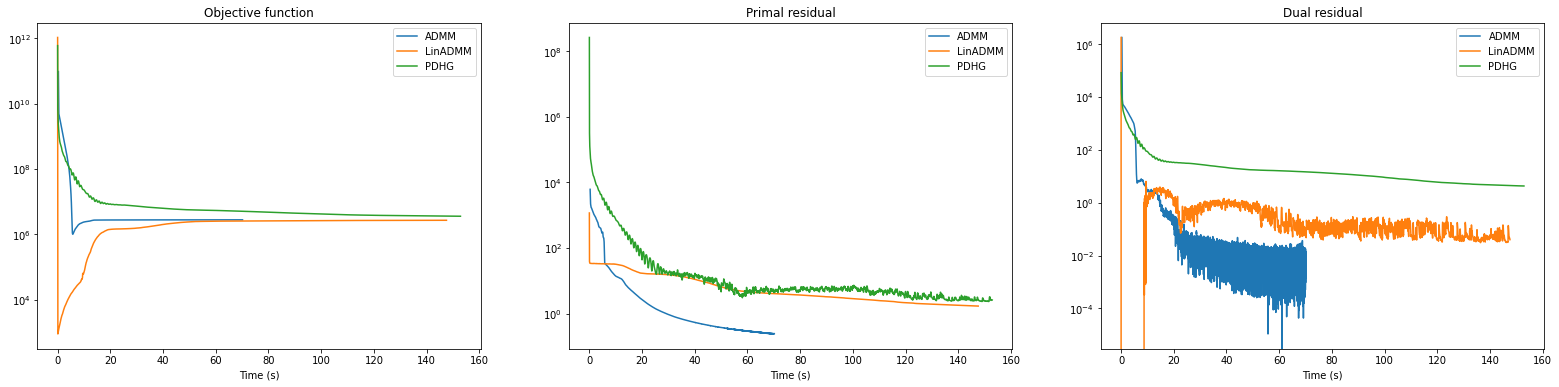

In [66]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)


fig.savefig("mri_solver_objective_comparison.png", dpi=1000, bbox_inches="tight")
fig.savefig("mri_solver_objective_comparison.eps", bbox_inches="tight")


fig.show()

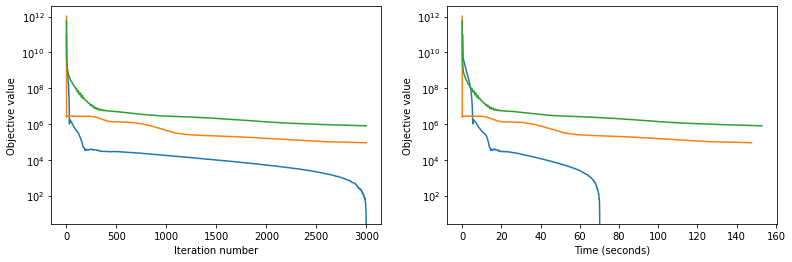

In [67]:
fig, axs = plt.subplots(1,2,figsize=(13,4))

# Objective value we are treating as fmin
approx_min_f_val = np.asarray(hist_admm.Objective[-1])

# Plot objective diff vs iteration
axs[0].semilogy( np.abs( np.asarray(hist_admm.Objective) - approx_min_f_val ) , label="ADMM")
axs[0].semilogy( np.abs( np.asarray(hist_ladmm.Objective) - approx_min_f_val ) , label="LinADMM")
axs[0].semilogy( np.abs( np.asarray(hist_pdhg.Objective) - approx_min_f_val ), label="PDHG")
axs[0].set_xlabel("Iteration number")
axs[0].set_ylabel("Objective value")

axs[1].semilogy( hist_admm.Time, np.abs( np.asarray(hist_admm.Objective) - approx_min_f_val ) , label="ADMM")
axs[1].semilogy( hist_ladmm.Time, np.abs( np.asarray(hist_ladmm.Objective) - approx_min_f_val ) , label="LinADMM")
axs[1].semilogy( hist_pdhg.Time, np.abs( np.asarray(hist_pdhg.Objective) - approx_min_f_val ) , label="PDHG")
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Objective value")

fig.savefig("mri_solver_objective_comparison_relative_to_ADMM.png", dpi=1000, bbox_inches="tight")
fig.savefig("mri_solver_objective_comparison_relative_to_ADMM.eps", bbox_inches="tight")


plt.show()


# Sinogram example

In [68]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, metric, plot
from scico.linop import Diagonal
from scico.linop.radon_svmbir import SVMBIRSquaredL2Loss, TomographicProjector
from scico.optimize import PDHG, LinearizedADMM
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

In [69]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

In [70]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, dtype=snp.float32)
A = TomographicProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

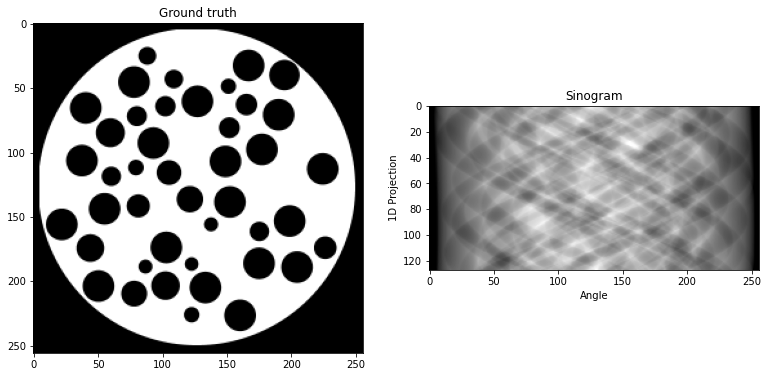

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(13,8))

axs[0].imshow(np.asarray(x_gt), cmap="gray")
axs[0].set_title("Ground truth")

axs[1].imshow(np.asarray(sino), cmap="gray")
axs[1].set_xlabel("Angle")
axs[1].set_ylabel("1D Projection")
axs[1].set_title("Sinogram")

fig.savefig("sinogram_data.png", dpi=1000, bbox_inches="tight")
fig.savefig("sinogram_data.eps", bbox_inches="tight")


plt.show()

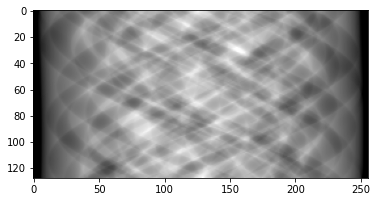

In [72]:
plt.imshow(np.asarray(sino), cmap="gray")
plt.show()

In [73]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

In [74]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

In [75]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

λ = 1e-1  # L1 norm regularization parameter

f = SVMBIRSquaredL2Loss(y=y, A=A, W=Diagonal(weights), scale=0.5)
g = λ * functional.L21Norm()  # regularization functional

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

In [76]:
solve_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[2e1],
    x0=x0,
    maxiter=50,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 10}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
x_admm = solve_admm.solve()
hist_admm = solve_admm.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_admm):.2f} dB\n")

Solving on GPU (Tesla T4)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  4.36e+00  8.928e+00  6.583e-01  5.653e-01     10  1.180e-03
  10  4.57e+01  1.604e+01  2.446e-02  3.015e-02      8  8.752e-05
  20  7.16e+01  1.615e+01  1.256e-02  1.155e-02      4  9.080e-05
  30  9.12e+01  1.619e+01  7.830e-03  7.858e-03      4  8.817e-05
  40  1.04e+02  1.622e+01  6.360e-03  6.734e-04      0  9.262e-05
  49  1.15e+02  1.622e+01  4.806e-03  4.874e-04      0  9.458e-05
PSNR: 22.93 dB



In [77]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=3e-2,
    nu=2e-1,
    x0=x0,
    maxiter=50,
    itstat_options={"display": True, "period": 10},
)
x_ladmm = solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB\n")

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.24e+00  5.302e+00  1.071e+00  1.100e+00
  10  1.28e+01  1.538e+01  1.336e-01  5.319e-02
  20  2.31e+01  1.580e+01  5.626e-02  2.221e-02
  30  3.28e+01  1.594e+01  3.318e-02  1.151e-02
  40  4.15e+01  1.601e+01  2.366e-02  6.896e-03
  49  4.90e+01  1.606e+01  1.878e-02  4.804e-03
PSNR: 22.86 dB



In [78]:
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=2e-2,
    sigma=8e0,
    x0=x0,
    maxiter=50,
    itstat_options={"display": True, "period": 10},
)
x_pdhg = solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)
print(f"PSNR: {metric.psnr(x_gt, x_pdhg):.2f} dB\n")

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.16e+00  2.244e+01  7.208e+00  1.056e+00
  10  1.17e+01  1.753e+01  1.777e+00  9.542e-02
  20  2.15e+01  1.676e+01  6.840e-01  4.022e-02
  30  3.11e+01  1.650e+01  2.999e-01  2.202e-02
  40  3.95e+01  1.640e+01  1.494e-01  1.489e-02
  49  4.65e+01  1.636e+01  9.499e-02  1.154e-02
PSNR: 22.92 dB



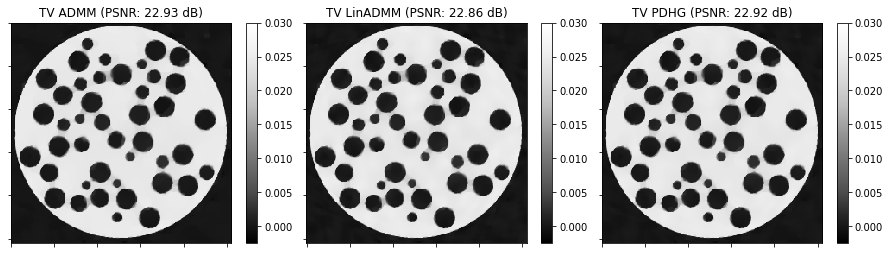

In [79]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
# fig, ax = plt.subplots(1, 2, figsize=[10, 5])
# plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
# plot.imview(
#     img=x_mrf,
#     title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
#     cbar=True,
#     fig=fig,
#     ax=ax[1],
#     norm=norm,
# )
# fig.show()

fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(
    img=x_admm,
    title=f"TV ADMM (PSNR: {metric.psnr(x_gt, x_admm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[0],
    norm=norm,
)
plot.imview(
    img=x_ladmm,
    title=f"TV LinADMM (PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_pdhg,
    title=f"TV PDHG (PSNR: {metric.psnr(x_gt, x_pdhg):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)



fig.savefig("sinogram_reconstructions.png", dpi=1000, bbox_inches="tight")
fig.savefig("sinogram_reconstructions.eps", bbox_inches="tight")



fig.show()

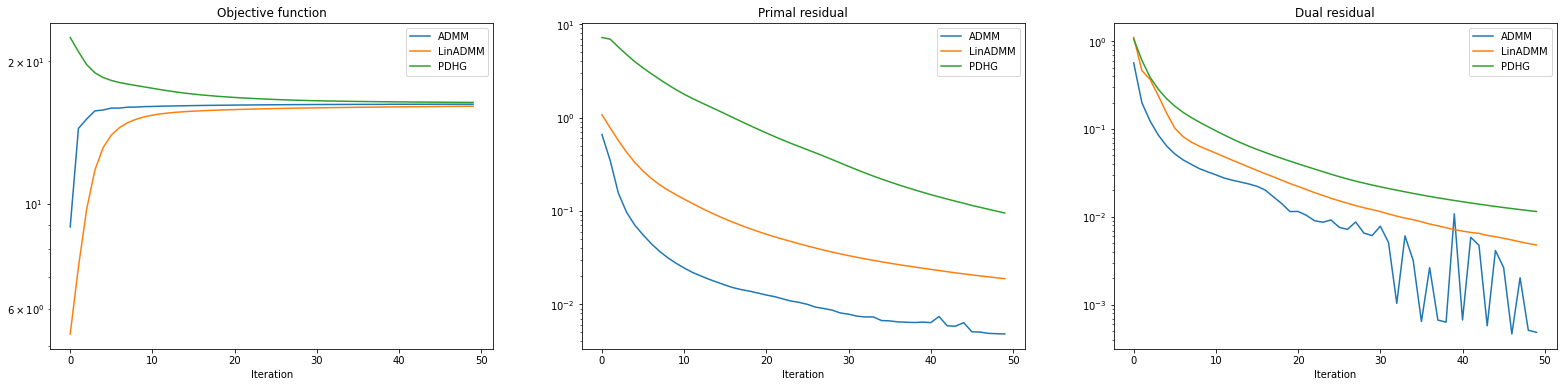

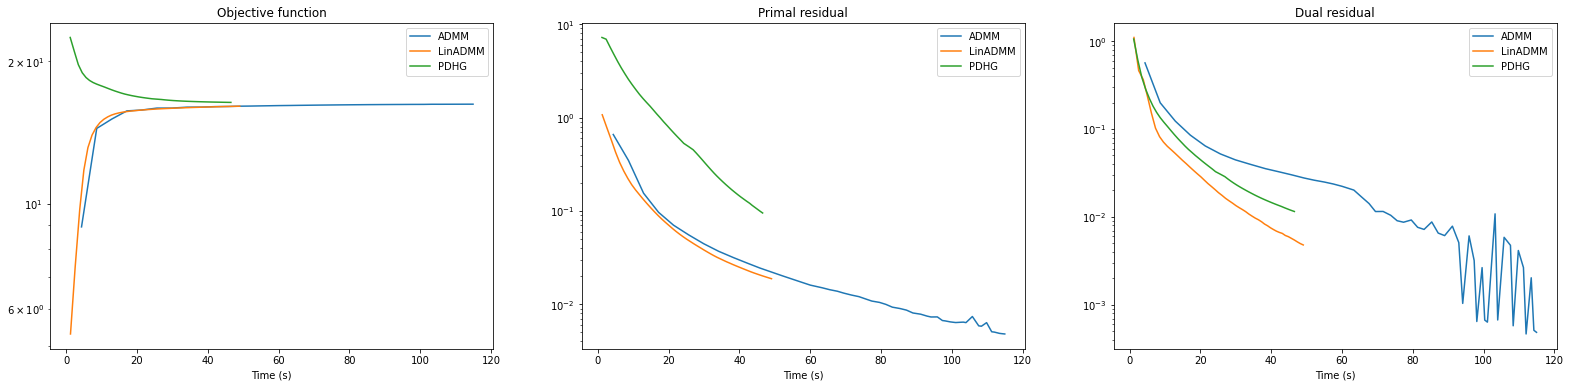

In [80]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)

fig.savefig("sinogram_solver_objective_comparison.png", dpi=1000, bbox_inches="tight")
fig.savefig("sinogram_solver_objective_comparison.eps", bbox_inches="tight")


fig.show()

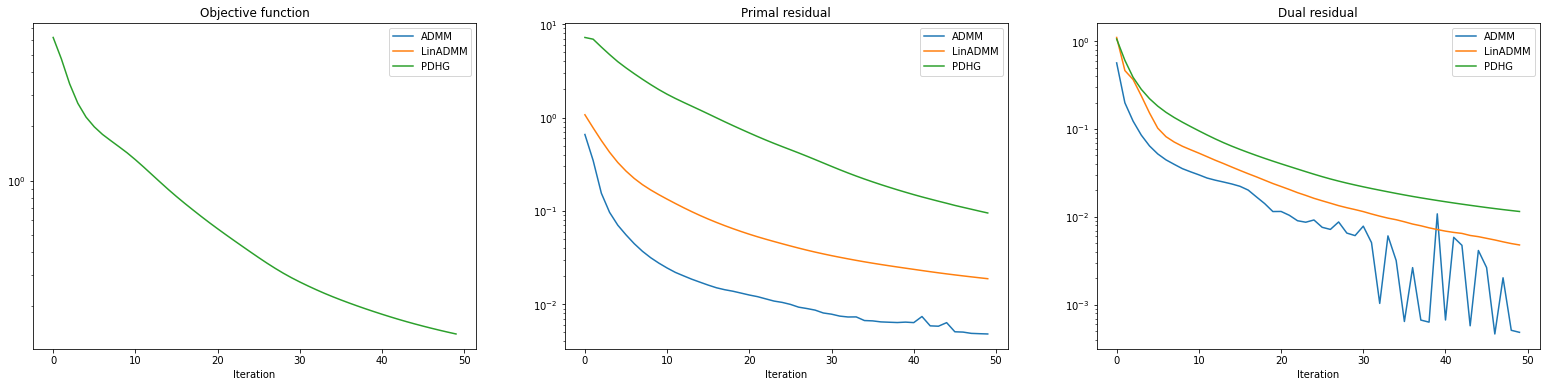

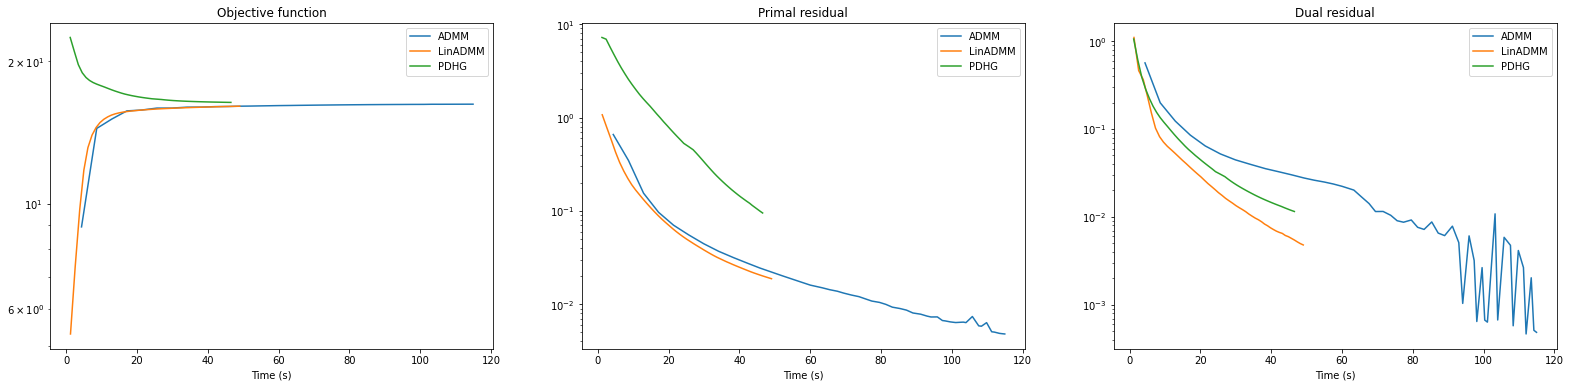

In [81]:
approx_min_f_val = np.asarray(hist_admm.Objective[-1])

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((np.asarray(hist_admm.Objective) - approx_min_f_val, np.asarray(hist_ladmm.Objective) - approx_min_f_val, np.asarray(hist_pdhg.Objective) - approx_min_f_val)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)


# fig.savefig("mri_solver_objective_comparison.png", dpi=1000, bbox_inches="tight")
# fig.savefig("mri_solver_objective_comparison.eps", bbox_inches="tight")

fig.show()

In [82]:
hist_admm.Objective[-1]

DeviceArray(16.221981, dtype=float32)

# De-blurring code

Note: you will need to restart the notebook for this part.

In [83]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize.admm import ADMM, CircularConvolveSolver
from scico.util import device_info
plot.config_notebook_plotting()

In [84]:
# Load the image


import os
import sys
import matplotlib.pyplot as plt
import numpy as np

from fastprogress import progress_bar


# Go back to MRI folder
os.chdir("Math76MRI")
os.listdir()

import os
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import numpy as np

img = Image.open("vader.jfif");
img = ImageOps.grayscale(img);

img = np.asarray(img)
img = img/255

plt.figure(figsize=(13,8))

plt.imshow(img, cmap="gray")


plt.show()


FileNotFoundError: ignored

In [ ]:
x_gt = jax.device_put(img)  # convert to jax type, push to GPU

In [ ]:
n = 20  # convolution kernel size
σ = 0.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.CircularConvolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

In [ ]:
plt.figure(figsize=(13,8))

plt.imshow(np.asarray(y), cmap="gray")

plt.show()


In [ ]:
λ = 2e-2  # L1 norm regularization parameter
ρ = 5e-1  # ADMM penalty parameter
maxiter = 300  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
g = λ * functional.L21Norm()  # regularization functionals gi
C = linop.FiniteDifference(x_gt.shape, circular=True)
solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=CircularConvolveSolver(),
    itstat_options={"display": True, "period": 10},
)

In [ ]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

In [ ]:
plt.figure(figsize=(13,8))

plt.imshow(np.asarray(x), cmap="gray")

plt.show()

In [ ]:
# Make the plot for the ground truth and the observation

fig, axs = plt.subplots(2, 1, figsize=(13,8))

axs[0].imshow(img, cmap="gray")
axs[0].set_title("Ground truth")

axs[1].imshow(np.asarray(y), cmap="gray")
axs[1].set_title("Observation")

fig.savefig("blurring_data.png", dpi=1000, bbox_inches="tight")
fig.savefig("blurring_data.eps", bbox_inches="tight")



plt.show()

### Do ADMM

In [ ]:
y_obs = y

In [ ]:
λ = 2e-2  # L1 norm regularization parameter
ρ = 5e-1  # ADMM penalty parameter
maxiter = 3000  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
g = λ * functional.L21Norm()  # regularization functionals gi
C = linop.FiniteDifference(x_gt.shape, circular=True)
solver_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=CircularConvolveSolver(),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
x = solver_admm.solve()
hist_admm = solver_admm.itstat_object.history(transpose=True)

### Do PDHG

In [ ]:
from scico.optimize import PDHG

solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=4e-2,
    sigma=4e-0,
    maxiter=3000,
    x0 = A.adj(y),
    itstat_options={"display": True, "period": 10},
    #subproblem_solver=CircularConvolveSolver(),
)

print(f"Solving on {device_info()}\n")
x_pdhg = solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)

### DO LADMM

In [ ]:
from scico.optimize import LinearizedADMM

solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=3e-2,
    nu=2e-1,
    x0 = A.adj(y),
    maxiter=3000,
    itstat_options={"display": True, "period": 10},
    #subproblem_solver=CircularConvolveSolver(),
)
x_ladmm = solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)
#print(f"PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB\n")

### Analyze the results

In [ ]:
admm_sol = np.real(np.asarray(solver_admm.x))[:,:]
ladmm_sol = np.real(np.asarray(solver_ladmm.x))[:,:]
pdhg_sol = np.real(np.asarray(solver_pdhg.x))[:,:]

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(13,13))

img = img

im1 = axs[0].imshow(admm_sol, cmap="gray")
ax1_divider = make_axes_locatable(axs[0])
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1)
axs[0].set_title("ADMM")

im2 = axs[1].imshow(ladmm_sol, cmap="gray")
ax2_divider = make_axes_locatable(axs[1])
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = fig.colorbar(im2, cax=cax2)
axs[1].set_title("LADMM")

im3 = axs[2].imshow(pdhg_sol, cmap="gray")
ax3_divider = make_axes_locatable(axs[2])
cax3 = ax3_divider.append_axes("right", size="7%", pad="2%")
cb3 = fig.colorbar(im3, cax=cax3)
axs[2].set_title("PDGH")

fig.show()

# for ax in axs.reshape(-1):
#     ax.set_xticks([])
#     ax.set_yticks([])
    
# fig.tight_layout()
    
fig.savefig("deblurring_solver_comparison.png", dpi=1000, bbox_inches="tight")
fig.savefig("deblurring_solver_comparison.eps", bbox_inches="tight")

# plt.show()

In [ ]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Prml_Rsdl, hist_ladmm.Prml_Rsdl, hist_pdhg.Prml_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)


fig.savefig("deblurring_solver_objective_comparison.png", dpi=1000, bbox_inches="tight")
fig.savefig("deblurring_solver_objective_comparison.eps", bbox_inches="tight")


fig.show()

In [ ]:
# Image we are denoising
img = phantom[None,:,:]
img = jax.device_put(img)

# Also bring the line mask onto GPU
mask_array = jax.device_put(R.flatten())
idx_nonzero = np.where(R.flatten() > 0)
idx_nonzero = jax.device_put(idx_nonzero)

# Define the DFT linear operator
dft_op = MyDFT(img.shape)

# Define the undersampling operator

eval_fn = lambda x: x.flatten()[idx_nonzero]
eval_fn_transpose = lambda x: x.T.flatten()[idx_nonzero]

undersampling_op = LinearOperator(img.shape, eval_fn=eval_fn, input_dtype=np.complex64)


# Define the composed operator
mri_op = undersampling_op @ dft_op

In [ ]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

In [ ]:
noise_sigma = 0.00
x_with_op_applied = mri_op._eval(img)
y_obs = x_with_op_applied + noise_sigma*jax.device_put( np.random.normal(size=x_with_op_applied.shape) )

BP = np.zeros(img.shape).astype(np.complex64)
BP = BP.flatten()
BP[idx_nonzero] = y_obs
BP = BP.reshape(img.shape)
BP = np.real(np.fft.ifft2(BP[0,:,:]))

plt.imshow(BP, cmap="gray")
plt.show()